In [1]:
# Uncomment for colab

# from google.colab import drive
# drive.mount('/content/drive')

# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 1 contains 5 main questions, including the bonus. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) The libraries needed to run this file. Except for numpy, scikit-learn, pandas, matplotlib

Your peers should be able to use the readme section for instructions and be able to run this file. 

Make sure to keep your answers concise. Maximum number of words is 1000, which you can count with the code below. (You can add around 600 words since we start at around 400).

In [2]:
# If this cell does not work try running `pip install nbformat`

# import io
# import nbformat

# nb = nbformat.read("Lab1_2021.ipynb", nbformat.NO_CONVERT)
# word_count = 0
# for cell in nb.cells:
#     if cell.cell_type == "markdown":
#         word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

# print("Word count:", word_count)

## Group Number : 10

## Student 1 
### Name : Sayak Mukherjee
### ID : 5222273

## Student 2
### Name : Vishruty Mittal
### ID : 5584825

## Readme - 

<!--Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.-->

The code is written on a conda environment with the following packages - numpy; pandas; matplotlib; seaborn; scikit-learn
The requirements file to create a replica of the enviroment is also provided with this code.

In [3]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import OneClassSVM

random.seed(0)

In [4]:
# Uncomment for colab

# !mkdir data

# !cp '/content/drive/MyDrive/Colab Notebooks/CDA/cda-lab-1-credit-card-fraud.zip' 'data/' # Location of data zipped file

# %cd data/

# !unzip cda-lab-1-credit-card-fraud.zip

# %cd ..

In [5]:
# Load Data

train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')

train_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


## Preprocess Data

In [6]:
ordinal_encoder = None

# Helper Function: Currency conversion
def currencyConverter(dataframe):
    """
      Args:
          dataframe: dataframe with 'amount' and 'currenycode' columns.

      Returns:
          converted_df: dataframe with 'amount' converted to USD
    """

    # Copy data to not mess with original
    converted_df = dataframe.copy()

    # Currency conversion rates as of 6-May-2022
    CurrencyRates = {
        'AUD': 0.7096,
        'GBP': 1.2360,
        'MXN': 0.0494,
        'NZD': 0.6427,
        'SEK': 0.1010
    }

    # Check if all currency conversion rates exists
    if not np.array_equal(np.array(list(CurrencyRates.keys())), np.unique(converted_df['currencycode'])):
        print('WARNING: Currency Rates not Found! Conversion Failed')
        return dataframe

    converted_df['amount_USD'] = converted_df.apply( lambda x: (x.amount * CurrencyRates[x.currencycode]), axis = 1)
    converted_df.drop('amount', axis=1, inplace=True)

    return converted_df

# Helper Function: Preprocess datasets
def preprocessData(dataframe, usage='train'):
    """
      Args:
          dataframe: dataframe to be preprocessed
          usage: purpose of the dataframe to be preprocssed
                 valid inputs: ['train', 'test', 'viz']

      Returns:
          preprocessed_df: preprocessed dataframe
    """

    assert usage in ('train', 'test', 'viz')

    global ordinal_encoder

    # Copy data to not mess with original
    preprocessed_df = dataframe.copy()
    dataset_columns = preprocessed_df.columns.tolist()
    dataset_columns = np.array(dataset_columns)
    dataset_columns = np.where(dataset_columns == 'amount', 'amount_USD', dataset_columns)

    # Convert Currency
    preprocessed_df = currencyConverter(preprocessed_df)
    
    # For training or viz drop the null values
    if usage in ('train', 'viz'):

        # Replace string NAs with empty strings
        preprocessed_df = preprocessed_df.apply(lambda x: '' if str(x).casefold() == 'na'.casefold() else x)

        # Drop rows with null values
        preprocessed_df = preprocessed_df.dropna()

    # Custom transformation of attributes
    preprocessed_df['ip_id'] = pd.to_numeric(preprocessed_df['ip_id'].str.replace('ip','')).astype(int)
    preprocessed_df['mail_id'] = pd.to_numeric(preprocessed_df['mail_id'].apply(lambda x: '0' if str(x).casefold() == 'emailna'.casefold() else x.replace('email',''))).astype(int)
    preprocessed_df['card_id'] = pd.to_numeric(preprocessed_df['card_id'].str.replace('card','')).astype(int)
    
    preprocessed_df['cardverificationcodesupplied'] = preprocessed_df['cardverificationcodesupplied'].apply(lambda x: 1 if x == True else 0)
    
    # For test replace null values by NA or 0
    if usage in ('test'):
        for col in dataset_columns:
                if isinstance(preprocessed_df[col][0], str):
                    preprocessed_df[col] = preprocessed_df[col].fillna('NA')
                else:
                    preprocessed_df[col] = preprocessed_df[col].fillna(0)
                
    # Run encoder only for training and testing, not viz
    if usage in ['train', 'test']:

        # Encode all categorical labels with label encoder
        column_list  = ['issuercountrycode', 
                        'currencycode', 
                        'shoppercountrycode', 
                        'accountcode', 
                        'mail_id', 
                        'ip_id', 
                        'card_id',
                        'txvariantcode', 
                        'shopperinteraction']  

        # Select only the categorical features to be encoded
        preprocessed_features = preprocessed_df[column_list]
        feature_columns = preprocessed_features.columns

        other_features = preprocessed_df[preprocessed_df.columns.difference(column_list)]

        if usage == 'train':
            ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            preprocessed_features = ordinal_encoder.fit_transform(preprocessed_features)
        
        else:
            preprocessed_features = ordinal_encoder.transform(preprocessed_features)
        
        preprocessed_df = None
        preprocessed_df = pd.DataFrame(preprocessed_features, columns=feature_columns)

        preprocessed_df = pd.concat([preprocessed_df.reset_index(drop=True), other_features.reset_index(drop=True)], axis=1)

    return preprocessed_df[dataset_columns]

In [7]:
train_df_viz = preprocessData(train_df, usage='viz')
train_df_viz.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,5562.00,GBP,GB,Ecommerce,1,1,UKAccount,132571,123779,250169,0
1,2,GB,mcdebit,557349.0,4196.22,GBP,GB,Ecommerce,1,1,UKAccount,312302,298387,14235,0
2,3,GB,mccredit,542011.0,4814.22,GBP,GB,Ecommerce,1,1,UKAccount,255027,260053,31944,0
3,4,GB,visadebit,465943.0,18966.42,GBP,GB,ContAuth,0,0,UKAccount,283167,54851,120871,0
4,6,GB,visadebit,475127.0,6297.42,GBP,GB,Ecommerce,1,1,UKAccount,325263,203929,208017,0


In [8]:
train_df = preprocessData(train_df, usage='train')
train_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,38.0,1.0,546097.0,5562.00,1.0,46.0,1.0,1,1,3.0,61603.0,54181.0,149872.0,0
1,2,38.0,2.0,557349.0,4196.22,1.0,46.0,1.0,1,1,3.0,144840.0,134713.0,8612.0,0
2,3,38.0,1.0,542011.0,4814.22,1.0,46.0,1.0,1,1,3.0,118502.0,117879.0,19183.0,0
3,4,38.0,7.0,465943.0,18966.42,1.0,46.0,0.0,0,0,3.0,131389.0,25422.0,72533.0,0
4,6,38.0,7.0,475127.0,6297.42,1.0,46.0,1.0,1,1,3.0,150797.0,91555.0,124563.0,0


In [9]:
test_df = preprocessData(test_df, usage='test')
test_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,0,38.0,7.0,492181.0,1353.42,1.0,46.0,1.0,0,1,3.0,-1.0,-1.0,-1.0
1,5,38.0,2.0,557379.0,6674.40,1.0,46.0,1.0,1,1,3.0,-1.0,-1.0,-1.0
2,7,38.0,9.0,492913.0,21642.36,1.0,46.0,1.0,1,1,3.0,-1.0,-1.0,-1.0
3,9,79.0,7.0,494310.0,9640.50,3.0,102.0,1.0,1,0,0.0,-1.0,-1.0,-1.0
4,16,7.0,1.0,518868.0,7841.08,0.0,8.0,1.0,1,0,0.0,-1.0,-1.0,-1.0


## 1. Visualization task – 1 A4

### 1a. Plot visulations 

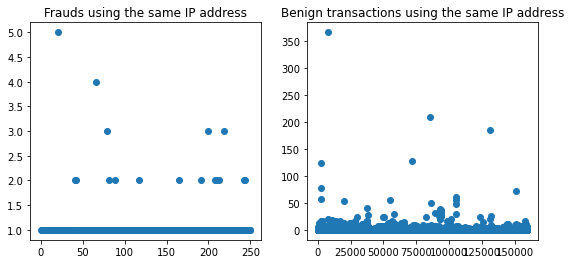

In [10]:
#plotting the number of the fraud and benign transactions per IP
plt.subplot(1,2,1)
plt.title('Frauds using the same IP address')
plt.scatter(np.arange(0, len(train_df_viz[(train_df_viz['label'] == 1)]['ip_id'].unique())), train_df_viz[train_df_viz['label'] == 1].groupby(['ip_id']).size())

plt.subplot(1,2,2)
plt.title('Benign transactions using the same IP address')
plt.scatter(np.arange(0, len(train_df_viz[(train_df_viz['label'] == 0)]['ip_id'].unique())), train_df_viz[train_df_viz['label'] == 0].groupby(['ip_id']).size())
plt.subplots_adjust(left=0.125, bottom=None, right=1.3, top=None, wspace=None, hspace=None)


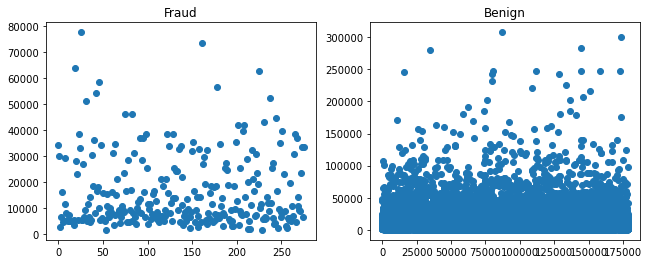

In [11]:
#plotting the relation between the fraud amount and benign amount
plt.subplot(1,2,1)
plt.title('Fraud')
plt.scatter(np.arange(0,train_df_viz[(train_df_viz['label'] == 1)].shape[0]), train_df_viz[train_df_viz['label'] == 1]['amount_USD'])

plt.subplot(1,2,2)
plt.title('Benign')
plt.scatter(np.arange(0,train_df_viz[(train_df_viz['label'] == 0)].shape[0]), train_df_viz[train_df_viz['label'] == 0]['amount_USD'])
plt.subplots_adjust(left=0.125, bottom=None, right=1.5, top=None, wspace=None, hspace=None)


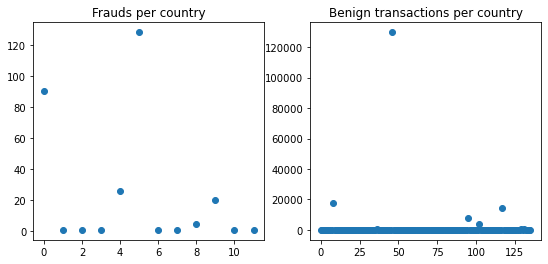

In [12]:
#plotting the number of the fraud and benign transactions per country
plt.subplot(1,2,1)
plt.title('Frauds per country')
plt.scatter(np.arange(0, len(train_df_viz[(train_df_viz['label'] == 1)]['shoppercountrycode'].unique())), train_df_viz[train_df_viz['label'] == 1].groupby(['shoppercountrycode']).size())

plt.subplot(1,2,2)
plt.title('Benign transactions per country')
plt.scatter(np.arange(0, len(train_df_viz[(train_df_viz['label'] == 0)]['shoppercountrycode'].unique())), train_df_viz[train_df_viz['label'] == 0].groupby(['shoppercountrycode']).size())
plt.subplots_adjust(left=0.125, bottom=None, right=1.3, top=None, wspace=None, hspace=None)


In [13]:
# Country with maximum fradulent transactions

train_df_viz[train_df_viz['label'] == 1].groupby(['shoppercountrycode']).count()['Id'] # Mexico

shoppercountrycode
AU     90
BG      1
BR      1
DE      1
GB     26
MX    128
NG      1
NO      1
NZ      5
SE     20
TH      1
US      1
Name: Id, dtype: int64

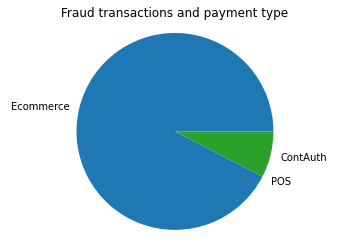

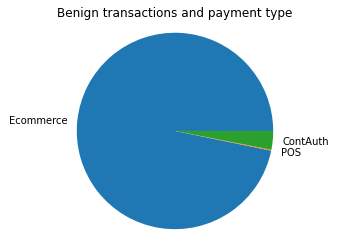

In [14]:
# Plotting the relation between Fraud transactions and Payment type
transactionType = [ train_df_viz[ (train_df_viz['shopperinteraction'] == 'Ecommerce') & (train_df_viz['label'] == 1)].shape[0],
                    train_df_viz[ (train_df_viz['shopperinteraction'] == 'POS') & (train_df_viz['label'] == 1)].shape[0],
                    train_df_viz[ (train_df_viz['shopperinteraction'] == 'ContAuth') & (train_df_viz['label'] == 1)].shape[0]]
                  
pieLabels=['Ecommerce', 'POS', 'ContAuth']
plt.pie(transactionType, labels= pieLabels)
plt.title('Fraud transactions and payment type')
plt.axis('equal')
plt.show()

transactionType = [ train_df_viz[ (train_df_viz['shopperinteraction'] == 'Ecommerce') & (train_df_viz['label'] == 0)].shape[0],
                    train_df_viz[ (train_df_viz['shopperinteraction'] == 'POS') & (train_df_viz['label'] == 0)].shape[0],
                    train_df_viz[ (train_df_viz['shopperinteraction'] == 'ContAuth') & (train_df_viz['label'] == 0)].shape[0]]
                  
pieLabels=['Ecommerce', 'POS', 'ContAuth']
plt.pie(transactionType, labels= pieLabels)
plt.title('Benign transactions and payment type')
plt.axis('equal')
plt.show()

### 1b. Describe the visualizations and provide relavant explanations of features and relations.

**Plot 1**

Looking at the first plot it can be observed that fraudsters generally commit frauds with different IPs and rarely use the same IP address for new frauds so as to reduce the chances of getting identified. 

**Plot 2**

From the second plot it can be inferred that majority of the frauds are of smaller amounts in comparison to the benign transactions. This might be to prevent attention on the transaction.

**Plot 3**

From the third plot it can be seen that there are certain countries with an exceptional high number of fradulent transactions. The highest number of fraudulent transactions in the dataset is observed from Mexico (MX).

<!-- Plot 3 suggests that multipe frauds from the same card are rare whereas benign transactions from the same card are very frequent. It might be because if fraudsters use the same card repeatedly, it might become easier to catch them.   -->

**Plot 4**

It can be inferred from the forth plot that maximum frauds are commited on E-Commerce transactions. This can be attributed to higher number of E-Commerce transactions in general or ease to commit E-Commerce frauds.

### 1c. Explain what features could be useful for discriminating between these two classes.

It can be concluded from the plots above that transaction amount, shopper country code and IP can be used as weak indicators for identifying fraudulent transactions.



## Initialise Classifiers

In [15]:
def init_Models():

    # Logistic Regression - White Box
    logisticReg = LogisticRegression(random_state=0)

    # Support Vector Machine - Black Box
    supportVector = OneClassSVM(gamma='auto')

    # Decision Tree - White Box
    decisionTree = DecisionTreeClassifier(random_state=0)

    # Random Forest - Black Box
    randomForest = RandomForestClassifier(max_depth=2, random_state=0)

    # Isolation Forest - Black Box
    isoForest = IsolationForest(random_state=0)

    return [logisticReg, supportVector, decisionTree, randomForest, isoForest]

In [16]:
# Defining the plotting function
def plotROC(models, trainX, testX, trainy, testy, title=''):
    """
      Args:
          models: list of models
          trainX: train features
          testX:  test feature
          trainy: train labels
          testy:  test labels
          title:  title of the plot

      Returns:
          score_values: ROC AUC scores for all the models
    """

    score_values = {}
    # Color map
    cmap = plt.cm.get_cmap('hsv', len(models)+1)

    # Random classifier performance
    probs = [0 for _ in range(len(testy))]
    uc = roc_auc_score(testy, probs)
    fpr, tpr, _ = roc_curve(testy, probs)
    plt.plot(fpr, tpr, marker='.', color='m', label='Random Classiifier')

    for ind, model in enumerate(tqdm(models)):

        if isinstance(model, LogisticRegression):
            model.fit(trainX, trainy)

        elif isinstance(model, OneClassSVM):
            model.fit(train_X)

        elif isinstance(model, DecisionTreeClassifier):
            model.fit(trainX, trainy)

        elif isinstance(model, RandomForestClassifier):
            model.fit(trainX, trainy)

        elif isinstance(model, IsolationForest):
            model.fit(train_X)

        else:
            print('Model instance not found')
            continue
        
        if not isinstance(model, IsolationForest):
            probs = model.predict_proba(testX)[:, 1]
        else:
            probs = abs(model.score_samples(testX)) # score

        uc = roc_auc_score(testy, probs)
        fpr, tpr, _ = roc_curve(testy, probs)
        plt.plot(fpr, tpr, marker='.', color=cmap(ind+1), label=type(model).__name__)
        score_values[type(model).__name__] = uc
    
    # Plotting the ROC curve for models
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    
    # Display the plot
    plt.show()   

    return score_values

In [17]:
# Train test split
train_X = train_df.drop(['label'], axis='columns')
train_y = train_df['label']
trainX, testX, trainy, testy = train_test_split(train_X, train_y, test_size=0.20, stratify=train_y, random_state = 0)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.44s/it]


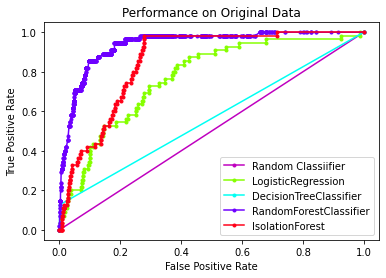

In [18]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values = plotROC([logisticReg, decisionTree, randomForest, isoForest], trainX, testX, trainy, testy, title='Performance on Original Data')

In [19]:
# Train test split with undersampling

percentage_bening = 0.7 # percentage of samples which are normal after undersampling

# undersample benign transactions
train_X_y = pd.concat([trainX.reset_index(drop=True), trainy.reset_index(drop=True)], axis=1)
undersample_frac = (len(train_X_y[train_X_y['label']==1])/(1 - percentage_bening) * percentage_bening)/len(train_X_y[train_X_y['label']==0])

fraud_train_df = train_X_y[train_X_y['label']==1]
benign_train_df = train_X_y[train_X_y['label']==0].sample(frac=undersample_frac)
undersampled_train_df = pd.concat([fraud_train_df, benign_train_df], ignore_index=True).reset_index(drop=True)

undersampled_train_X = undersampled_train_df.drop(['label'], axis='columns')
undersampled_train_y = undersampled_train_df['label']

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


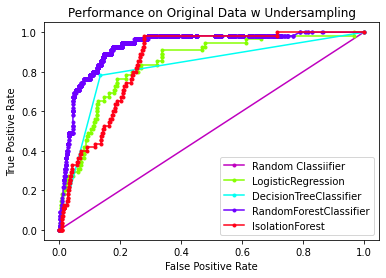

In [20]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_us = plotROC([logisticReg, decisionTree, randomForest, isoForest], undersampled_train_X, testX, undersampled_train_y, testy, title='Performance on Original Data w Undersampling')

In [21]:
# Compare performance over original vs undersampled data

pd.DataFrame({'Original Data': score_values, 'Undersampling': score_values_us})

,Original Data,Undersampling
LogisticRegression,0.771701,0.841591
DecisionTreeClassifier,0.563048,0.823704
RandomForestClassifier,0.939457,0.928565
IsolationForest,0.854750,0.854750


## 2. Imbalance task – 1 A4 – Sayak Mukherjee

In [22]:
# Split data into fraudulent and benign
fraud_dataX = trainX[trainy==1]
fraud_datay = trainy[trainy==1]

benign_dataX = trainX[trainy==0]
benign_datay = trainy[trainy==0]

print(f'There are {round(fraud_dataX.shape[0]/trainX.shape[0]*100, 3)}% \
fraudulent samples and {round(benign_datay.shape[0]/trainX.shape[0]*100, 3)}% \
benign sample.')

There are 0.155% fraudulent samples and 99.845% benign sample.


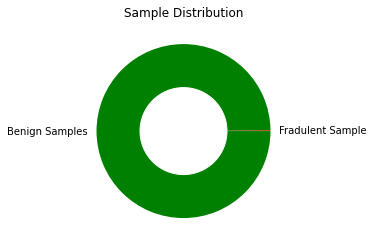

In [23]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.5, color='white')

plt.pie([fraud_dataX.shape[0], benign_dataX.shape[0]], 
        labels=['Fradulent Sample', 'Benign Samples'], 
        colors=['red','green'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sample Distribution')
plt.show()

In [24]:
# SMOTE Algorithm
# Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: 
# synthetic minority over-sampling technique. Journal of artificial intelligence 
# research, 16, 321-357.
# https://www.jair.org/index.php/jair/article/view/10302

# For handling categorical data (ordinal encoded) a customisation is applied on
# the original algorithm. Attribute values are selected at random between the 
# sample and the selected neighbor. This feature can be optionally applied by 
# setting the custom argument to true.

def smote(minority_X, minority_y, percentage, neighbors, custom=False):
    """
      Args:
          minority_X: features for minority class
          minority_y: labels for minority class
          percentage: percentage of SMOTEing
          neighbors:  number of neighbors to be considered
          custom:     apply custom handling for categorical data

      Returns:
          minority_samples: 
          minority_samples:
    """

    # Copy data to not mess with original
    minority_samples = minority_X.copy()
    minority_labels = minority_y.copy()

    col_names = minority_samples.columns

    num_samples = minority_samples.shape[0]

    # If N is less than 100% the minority class is 
    # randomised as a sample from them will be SMOTEd
    if percentage < 100:
        
        # Randomly sample a fraction of datapoints
        fraction = percentage/100
        minority_samples = minority_samples.sample(frac=fraction).reset_index(drop=True)

        # Reset the number of minority samples and percentage
        num_samples = minority_samples.shape[0]
        percentage = 100

    fraction = (int)(percentage/100)
    numattrs = minority_samples.shape[1]
    newindex = 0
    newindexes = [ind for ind in range(num_samples*fraction)]
    synthetic = pd.DataFrame(np.nan, index = newindexes, columns=minority_samples.columns)
    nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='kd_tree').fit(minority_samples.values)

    # For each minority sample apply SMOTE
    for sample in range(num_samples):

        # Find neighbors of the current sample
        _, nnarray = nbrs.kneighbors([minority_samples.iloc[sample]])

        # Fill with synthetic data based on randomly selected neighbor
        for ind in range(fraction):
            nn = random.choice(range(neighbors))

            for attr in range(numattrs):
                # Apply SMOTE for amount columns
                if col_names[attr] in ['amount_USD'] or not custom:
                  diff = minority_samples.iloc[nnarray[0][nn]][attr] - minority_samples.iloc[sample][attr]
                  gap = random.uniform(0, 1)
                  synthetic.iloc[newindex][attr] = minority_samples.iloc[sample][attr] + gap * diff

                # Randomly copy neighbor or sample value 
                else:
                  choice = random.choice(range(2))
                  if choice == 0:
                      synthetic.iloc[newindex][attr] = minority_samples.iloc[nnarray[0][nn]][attr]
                  else:
                      synthetic.iloc[newindex][attr] = minority_samples.iloc[sample][attr] 
            newindex += 1
    
    minority_samples = pd.concat([synthetic,  minority_samples], ignore_index=True).reset_index(drop=True)
    minority_labels = np.full(len(minority_samples), minority_labels.reset_index(drop=True)[0])

    return minority_samples, pd.Series(minority_labels)

In [25]:
# Create the training dataframe by appending synthetic data to the original dataframe
smoted_fraud_dataX, smoted_fraud_datay = smote(fraud_dataX, fraud_datay, 4000, 6, custom=True)

smoted_trainX = pd.concat([smoted_fraud_dataX, benign_dataX], ignore_index=True).reset_index(drop=True)
smoted_trainy = pd.concat([smoted_fraud_datay, benign_datay], ignore_index=True).reset_index(drop=True)
smoted_trainX.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,160431.0,74.0,5.0,477291.0,4753.517924,2.0,95.0,1.0,1.0,0.0,1.0,76214.0,48071.0,95673.0
1,151947.0,74.0,9.0,492910.0,12574.497667,2.0,95.0,1.0,1.0,0.0,1.0,77250.0,48016.0,95673.0
2,160431.0,38.0,9.0,492910.0,10656.223999,2.0,46.0,1.0,1.0,1.0,1.0,77250.0,57338.0,113185.0
3,152198.0,74.0,5.0,477291.0,7865.507504,2.0,95.0,1.0,1.0,0.0,1.0,123435.0,48016.0,95673.0
4,160431.0,74.0,5.0,477291.0,2949.180000,2.0,95.0,1.0,1.0,0.0,1.0,117311.0,48016.0,95673.0


In [26]:
# Check the ratio after SMOTE

print(f'There are {round(smoted_fraud_dataX.shape[0]/smoted_trainX.shape[0]*100, 3)}% \
fraudulent samples and {round(benign_dataX.shape[0]/smoted_trainX.shape[0]*100, 3)}% \
benign sample after SMOTE.')

There are 5.966% fraudulent samples and 94.034% benign sample after SMOTE.


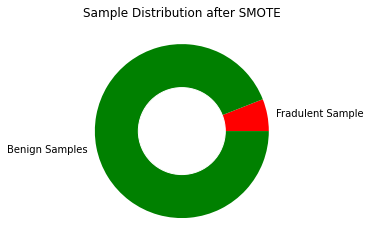

In [27]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.5, color='white')

plt.pie([smoted_fraud_dataX.shape[0], benign_dataX.shape[0]], 
        labels=['Fradulent Sample', 'Benign Samples'], 
        colors=['red','green'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sample Distribution after SMOTE')
plt.show()

In [28]:
# Applying SMOTE + Undersampling
benign_df = pd.concat([benign_dataX.reset_index(drop=True), benign_datay.reset_index(drop=True)], axis=1)

percentage_bening = 0.7 # percentage of samples which are normal after undersampling

# undersample benign transactions
undersample_frac = (len(smoted_fraud_dataX)/(1 - percentage_bening) * percentage_bening)/len(benign_df)
undersampled_benign_df = benign_df.sample(frac=undersample_frac)

undersampled_benignX = undersampled_benign_df.drop('label', axis=1)
undersampled_benigny = undersampled_benign_df['label']

smoted_undersampled_trainX = pd.concat([smoted_fraud_dataX, undersampled_benignX], ignore_index=True).reset_index(drop=True)
smoted_undersampled_trainy = pd.concat([smoted_fraud_datay, undersampled_benigny], ignore_index=True).reset_index(drop=True)
smoted_undersampled_trainX.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,160431.0,74.0,5.0,477291.0,4753.517924,2.0,95.0,1.0,1.0,0.0,1.0,76214.0,48071.0,95673.0
1,151947.0,74.0,9.0,492910.0,12574.497667,2.0,95.0,1.0,1.0,0.0,1.0,77250.0,48016.0,95673.0
2,160431.0,38.0,9.0,492910.0,10656.223999,2.0,46.0,1.0,1.0,1.0,1.0,77250.0,57338.0,113185.0
3,152198.0,74.0,5.0,477291.0,7865.507504,2.0,95.0,1.0,1.0,0.0,1.0,123435.0,48016.0,95673.0
4,160431.0,74.0,5.0,477291.0,2949.180000,2.0,95.0,1.0,1.0,0.0,1.0,117311.0,48016.0,95673.0


In [29]:
# Check the ratio after SMOTE + Undersampling

print(f'There are {round(smoted_fraud_dataX.shape[0]/smoted_undersampled_trainX.shape[0]*100, 3)}% \
fraudulent samples and {round(undersampled_benignX.shape[0]/smoted_undersampled_trainX.shape[0]*100, 3)}% \
benign sample after SMOTE.')

There are 30.0% fraudulent samples and 70.0% benign sample after SMOTE.


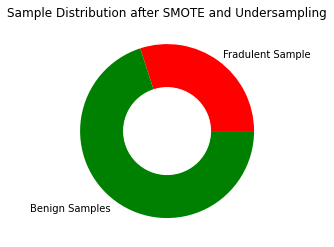

In [30]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.5, color='white')

plt.pie([smoted_fraud_dataX.shape[0], undersampled_benignX.shape[0]], 
        labels=['Fradulent Sample', 'Benign Samples'], 
        colors=['red','green'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Sample Distribution after SMOTE and Undersampling')
plt.show()

### 2a. Print ROC curves

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.59s/it]


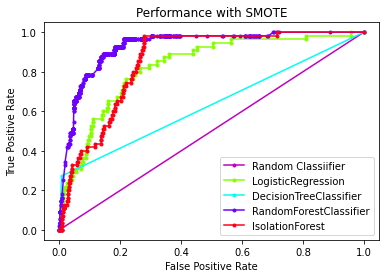

In [31]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_smote = plotROC([logisticReg, decisionTree, randomForest, isoForest], 
                             smoted_trainX, 
                             testX, 
                             smoted_trainy, 
                             testy, 
                             title='Performance with SMOTE')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]


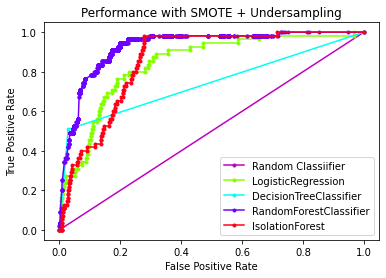

In [32]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_smote_us = plotROC([logisticReg, decisionTree, randomForest, isoForest], 
                                smoted_undersampled_trainX, 
                                testX, 
                                smoted_undersampled_trainy, 
                                testy, 
                                title='Performance with SMOTE + Undersampling')

### 2b. Analyse the performance of the classifiers. Explain which method performs best.

In [33]:
# Compare performance over original vs undersampled data

pd.DataFrame({'Original Data': score_values, 
              'Undersampling': score_values_us,
              'SMOTE': score_values_smote,
              '[SMOTE + Undersampling]': score_values_smote_us})

,Original Data,Undersampling,SMOTE,[SMOTE + Undersampling]
LogisticRegression,0.771701,0.841591,0.829254,0.841984
DecisionTreeClassifier,0.563048,0.823704,0.632653,0.740247
RandomForestClassifier,0.939457,0.928565,0.930195,0.926648
IsolationForest,0.854750,0.854750,0.854750,0.854750


From the above ROC curve and AUC values, we can infer that Random Forest Classifier is the best among the selected models when using SMOTEd training data. Among the white box methods the best performing model is Logistic Regression. The superior performce of the Random Forest model could be due to its architecture - it is an ensemble created using bagging. Thereby Random Forest can decrease the variance significantly as compared to the other models. 

Also we can notice that smote coupled with undersampling of benign datapoints improves the performance of both the white box models. 

### 2c. Is using SMOTE a good idea? Why (not)?

Overall, majority of the models have shown an improvement in AUC values. This is expected as prior distribution of the both the classes becomes more evenly distributed. Hence the use of SMOTEing is a good idea.

## 3. Privacy task – 1 A4 – Vishruty Mittal

In [34]:
# Define rank swapping algorithm
def rank_swapping(df_swap, column, p=10):
    """
      Args:
          df_swap: data frame on which rank swapping is to be performed
          column: columns to be swapped
          p: percentage of neighbours considered for swapping

      Returns:
          df_swap: swapped data frame
    """ 
    max_length = len(df_swap)
    p = int(p * 0.01 * max_length)
    columns = list(df_swap.columns)
    column_index = columns.index(column)
    df_swap = df_swap.sort_values(by=column)
    df_swap = df_swap.reset_index(drop=True)

    for current_index in range(0, max_length):
        while True:
            swap_index = current_index + random.randint(-p,p)
            if (swap_index < max_length - 1) and (swap_index >= 0) and (swap_index != current_index):
                break
        df_swap.at[current_index, column], df_swap.at[swap_index, column] = df_swap.at[swap_index, column] , df_swap.at[current_index, column]
    return df_swap

In [35]:
#Apply Rank swapping on identifiers and quasi identifiers
identity_columns = ['mail_id', 'ip_id', 'card_id']

swapped_trainX_df = trainX
for column in identity_columns:
      swapped_trainX_df = rank_swapping(swapped_trainX_df, column)
swapped_trainX_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,226994,24.0,8.0,438088.0,9827.96,0.0,8.0,1.0,1,0,0.0,7483.0,28435.0,16071.0
1,111732,38.0,1.0,552213.0,8151.42,1.0,46.0,1.0,1,1,3.0,30750.0,115503.0,1286.0
2,37265,38.0,7.0,492181.0,3578.22,1.0,46.0,1.0,1,1,3.0,53085.0,108789.0,9066.0
3,187853,74.0,4.0,493136.0,11060.66,2.0,95.0,1.0,1,0,1.0,118272.0,38310.0,5694.0
4,212500,38.0,1.0,542598.0,6180.00,1.0,46.0,1.0,1,1,3.0,111968.0,82938.0,991.0


In [36]:
#Apply Rank swapping on identifiers and quasi identifiers over undersampled data
identity_columns = ['mail_id', 'ip_id', 'card_id']

swapped_us_trainX_df = undersampled_train_X
for column in identity_columns:
      swapped_us_trainX_df = rank_swapping(swapped_us_trainX_df, column)
swapped_us_trainX_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,171008,93.0,1.0,520991.0,39693.00,4.0,117.0,1.0,1,1,2.0,155794.0,106166.0,11973.0
1,66993,38.0,7.0,465945.0,2342.22,1.0,46.0,1.0,1,1,3.0,45277.0,118389.0,2309.0
2,196998,93.0,2.0,554501.0,19543.50,4.0,117.0,1.0,1,1,2.0,127170.0,85344.0,7830.0
3,220640,93.0,7.0,455262.0,9584.90,4.0,117.0,1.0,1,1,2.0,120382.0,35007.0,10059.0
4,218251,7.0,1.0,521729.0,7841.08,0.0,8.0,1.0,1,0,0.0,118541.0,50590.0,114.0


In [37]:
#Apply Rank swapping on identifiers and quasi identifiers over SMOTEd data
identity_columns = ['mail_id', 'ip_id', 'card_id']

swapped_smote_trainX_df = smoted_trainX
for column in identity_columns:
      swapped_smote_trainX_df = rank_swapping(swapped_smote_trainX_df, column)
swapped_smote_trainX_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,226994.0,24.0,8.0,438088.0,9827.96,0.0,8.0,1.0,1.0,0.0,0.0,16713.0,16516.0,1307.0
1,111732.0,38.0,1.0,552213.0,8151.42,1.0,46.0,1.0,1.0,1.0,3.0,7385.0,113787.0,4633.0
2,37265.0,38.0,7.0,492181.0,3578.22,1.0,46.0,1.0,1.0,1.0,3.0,34212.0,97347.0,10413.0
3,187853.0,74.0,4.0,493136.0,11060.66,2.0,95.0,1.0,1.0,0.0,1.0,128556.0,36078.0,15785.0
4,212500.0,38.0,1.0,542598.0,6180.00,1.0,46.0,1.0,1.0,1.0,3.0,111860.0,119800.0,848.0


In [38]:
#Apply Rank swapping on identifiers and quasi identifiers over SMOTEd and undersampled data
identity_columns = ['mail_id', 'ip_id', 'card_id']

swapped_smoted_us_trainX_df = smoted_undersampled_trainX
for column in identity_columns:
      swapped_smoted_us_trainX_df = rank_swapping(swapped_smoted_us_trainX_df, column)
swapped_smoted_us_trainX_df.head()

,Id,issuercountrycode,txvariantcode,bin,amount_USD,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,212500.0,38.0,1.0,542598.0,6180.000000,1.0,46.0,1.0,1.0,1.0,3.0,104954.0,106833.0,1181.0
1,59903.0,38.0,7.0,475130.0,3269.220000,1.0,46.0,1.0,1.0,1.0,3.0,92563.0,152269.0,3125.0
2,11180.0,38.0,5.0,454638.0,16562.400000,1.0,46.0,1.0,1.0,1.0,3.0,101044.0,39228.0,14528.0
3,134372.0,93.0,1.0,541256.0,13029.000000,4.0,8.0,1.0,1.0,1.0,2.0,123627.0,65101.0,2391.0
4,171008.0,7.0,1.0,552033.0,40722.876387,0.0,8.0,1.0,1.0,0.0,0.0,160674.0,106721.0,12504.0


### 3a. Print ROC curves

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.73s/it]


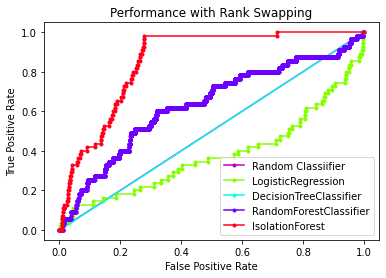

In [39]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_rs = plotROC([logisticReg, decisionTree, randomForest, isoForest], 
                          swapped_trainX_df, 
                          testX, 
                          trainy, 
                          testy, 
                          title='Performance with Rank Swapping')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.24it/s]


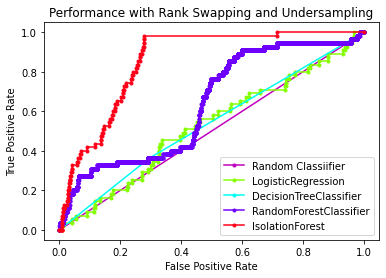

In [40]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_rs_us = plotROC([logisticReg, decisionTree, randomForest, isoForest], 
                             swapped_us_trainX_df, 
                             testX, 
                             undersampled_train_y, 
                             testy, 
                             title='Performance with Rank Swapping and Undersampling')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.46s/it]


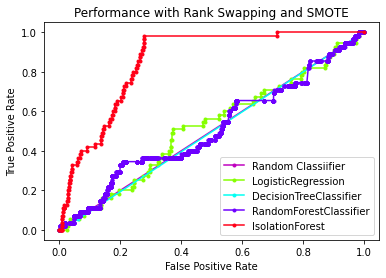

In [41]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_smote_rs = plotROC([logisticReg, decisionTree, randomForest, isoForest], 
                                swapped_smote_trainX_df, 
                                testX, 
                                smoted_trainy, 
                                testy, 
                                title='Performance with Rank Swapping and SMOTE')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]


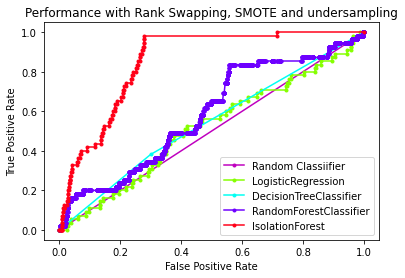

In [42]:
logisticReg, _, decisionTree, randomForest, isoForest = init_Models()

score_values_smote_us_rs = plotROC([logisticReg, decisionTree, randomForest, isoForest], 
                                   swapped_smoted_us_trainX_df, 
                                   testX, 
                                   smoted_undersampled_trainy, 
                                   testy, 
                                   title='Performance with Rank Swapping, SMOTE and undersampling')

### 3b. Analyse the performance of the classifiers. Explain which method performs best.

In [43]:
# Compare performance over original vs undersampled data

pd.DataFrame({'Original Data': score_values, 
              'Undersampling': score_values_us,
              'Rank Swaping': score_values_rs,
              '[Rank Swaping + Undersampling]': score_values_rs_us,
              '[Rank Swaping + SMOTE]': score_values_smote_rs,
              '[Rank Swaping + SMOTE + Undersampling]': score_values_smote_us_rs})

,Original Data,Undersampling,Rank Swaping,[Rank Swaping + Undersampling],[Rank Swaping + SMOTE],[Rank Swaping + SMOTE + Undersampling]
LogisticRegression,0.771701,0.841591,0.378539,0.526062,0.517581,0.516776
DecisionTreeClassifier,0.563048,0.823704,0.499020,0.533852,0.496226,0.541038
RandomForestClassifier,0.939457,0.928565,0.632819,0.636092,0.509916,0.589374
IsolationForest,0.854750,0.854750,0.854750,0.854750,0.854750,0.854750


From the above ROC curve and AUC values, it can be seen that the performance of  only Isolation Forest doesn't deteriorate due to rank swapping. The Logistic Regression is most affected model. Overall, the best performing model is Isolation Forest and the best among the white box models is Decision Tree Classifier.

### 3c. Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

No significant difference in ROC curve and AUC score for isolation forest could be because it looks at the difference of an attribute value from the rest of the data. Rankswapping on the personal identifiable columns doesn't necessarily affect the separation in identifiable attributes. Whereas the swapped fields might have been an important feature for the rest of the classifiers. Moreover, Random Forest was still able to perform better because of ensembling and bagging than the rest.

It is always advisable to protect user's privacy while using machine learning models. Therefore, models like isolation forest can be a good option to select as there is no significant deterioration in the performance despite swapping identifiable information.

## 4. Classification task – 2 A4

Based on the above discussions we decided to implement only SMOTE for section 4. The below classifiers were selected on the basis of their performance plots  in the prior sections:


*   Random Forest Classifier [BLACK BOX]
*   Logistic Regression [WHITE BOX]




In [44]:
#Setting up 10 fold cross validation to train a black box and a white box classifier 
def ten_fold_cross_validation(classifier, features, labels):  
    """
      Args:
          classifier: classifier object
          features: dataframe of training features
          labels: dataframe of training labels
    """ 
    
    percentage_bening = 0.7 # percentage of samples which are normal after undersampling

    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    TP_all = []
    FP_all = []
    TN_all = []
    FN_all = []
    AUC_all = []
    accuracy=[]

    with tqdm(total=k_fold.get_n_splits(features, labels)) as pbar:
    
        for train_index, test_index in k_fold.split(features, labels):
            train_feature, test_feature = features.iloc[train_index], features.iloc[test_index]
            train_label, test_label = labels.iloc[train_index], labels.iloc[test_index]
            
            # Apply SMOTE-ing on train data
            fraud_dataX = train_feature[train_label==1]
            fraud_datay = train_label[train_label==1]
            benign_dataX = train_feature[train_label==0]
            benign_datay = train_label[train_label==0]

            smoted_fraud_dataX, smoted_fraud_datay = smote(fraud_dataX, fraud_datay, 4000, 6, custom=True)

            # Apply Undersampling on train data
            benign_df = pd.concat([benign_dataX.reset_index(drop=True), benign_datay.reset_index(drop=True)], axis=1)

            undersample_frac = (len(smoted_fraud_dataX)/(1 - percentage_bening) * percentage_bening)/len(benign_df)
            undersampled_benign_df = benign_df.sample(frac=undersample_frac)
            undersampled_benignX = undersampled_benign_df.drop('label', axis=1)
            undersampled_benigny = undersampled_benign_df['label']

            smoted_undersampled_trainX = pd.concat([smoted_fraud_dataX, undersampled_benignX], ignore_index=True).reset_index(drop=True)
            smoted_undersampled_trainy = pd.concat([smoted_fraud_datay, undersampled_benigny], ignore_index=True).reset_index(drop=True)

            # Fit Classifier
            classifier.fit(smoted_undersampled_trainX, smoted_undersampled_trainy)      
            pred_label = classifier.predict(test_feature)

            # Calculating different performance metrics
            conf_matrix = confusion_matrix(test_label, pred_label)
            acc= accuracy_score(test_label, pred_label)*100
            TN = conf_matrix[0][0]
            FN = conf_matrix[1][0]
            TP = conf_matrix[1][1]
            FP = conf_matrix[0][1]

            if not isinstance(classifier, IsolationForest):
                pred_label_probab = classifier.predict_proba(test_feature)[:, 1]
            else:
                pred_label_probab = abs(classifier.score_samples(test_feature)) # score
            
            AUC = roc_auc_score(test_label, pred_label_probab)     

            TP_all.append(TP)
            FP_all.append(FP)
            TN_all.append(TN)
            FN_all.append(FN)
            AUC_all.append(AUC)
            accuracy.append(acc)

            pbar.update(1)

    TP_all = np.array(TP_all)
    FP_all = np.array(FP_all)
    TN_all = np.array(TN_all)
    FN_all = np.array(FN_all)
    AUC_all = np.array(AUC_all)
    accuracy=np.array(accuracy)

    print("")
    print("Accuracy: {}".format(np.mean(accuracy)))
    print("AUC: {}".format(np.sum(AUC)))
    print("True positives: {}".format(np.sum(TP_all)))
    print("False positives: {}".format(np.sum(FP_all)))
    print("True negatives: {}".format(np.sum(TN_all)))
    print("False negatives: {}".format(np.sum(FN_all)))

### 4a. Print relevant plots and metrics with clear headings.

In [45]:
# Random Forest Classifier [BLACK BOX]

classifier_rf = RandomForestClassifier(max_depth=6, random_state=0)

ten_fold_cross_validation(classifier_rf, train_X, train_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:43<00:00, 28.36s/it]


Accuracy: 94.14291525070405
AUC: 0.9319335851532928
True positives: 213
False positives: 10409
True negatives: 168107
False negatives: 63


In [46]:
# Logistic Regression [WHITE BOX]

classifier_lg = LogisticRegression(random_state=0)

ten_fold_cross_validation(classifier_lg, train_X, train_y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:18<00:00, 25.81s/it]


Accuracy: 89.61363111685525
AUC: 0.8481397600774666
True positives: 142
False positives: 18436
True negatives: 160080
False negatives: 134


### 4b. Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.

Random Forest Classifier is a better performer than Logistic Regression in this usecase because of the following metrics. 

*   It has a higher accuracy score which means predicted labels are the same as actual labels in 94% of the datapoints
*   It has higher AUC score which means it has a higher area under the ROC curve.
*   It has higher true positive i.e it could correctly flag the fraud samples for more datapoints than Logistic Regression.
*   Random Forest Classifier has lower false positive i.e it correctly did not flag benign transactions as fradulant, for more datapoints than Logistic Regression.
*   It could predict actual benign transactions as benign for more datapoints than Logistic Regression. 
*   It has low false negatives i.e it predicted fraud transactions as benign less than Logistic Regression.







### 4c. Explain when your white-box classifier predicts transactions as fraudulent

Logistic Regression classifies datapoints as fradulant or benign on the basis of coefficient values. Hence it is easy to explain why a certain point got marked as fraud or benign.Below it can be seen what weights were assigned to each parameter in our Logistic Regression Classifier.

We notice a high positive coefficient for shopperCountryCode for labelling a transaction as fradulant/benign. The same was observed in vizualization plot as well where certain countries had a high fradulant rate.

A similar high value can also be seen in issuerCountryCode. 
Hence we can conclude country plays a significant role in classification.

In [47]:
# Feature importance
pd.DataFrame(classifier_lg.coef_.transpose(), index = train_X.columns, columns=['coefficient'])

,coefficient
Id,-1.201708e-06
issuercountrycode,8.298875e-03
txvariantcode,-6.293134e-04
bin,-1.966732e-06
amount_USD,9.817889e-05
currencycode,2.097770e-04
shoppercountrycode,1.136362e-02
shopperinteraction,-3.874482e-05
cardverificationcodesupplied,-3.883813e-05
cvcresponsecode,-3.385490e-04


## 5. Bonus task – 1 A4

### 5a. Provide code and report below

## Generate Predictions on test set

In [48]:
# Test the classifier on test_data.csv file
def generate_predictions(classifier, output_df):

    # Train the data using shared train_data.csv file
    train_X = train_df.drop(['label'], axis='columns')
    train_y = train_df['label']

    fraud_data_X = train_X[train_y==1]
    fraud_data_y = train_y[train_y==1]
    benign_data_X = train_X[train_y==0]
    benign_data_y = train_y[train_y==0]

    smoted_fraud_dataX, smoted_fraud_datay = smote(fraud_data_X, fraud_data_y, 4000, 6, custom=True)

    # Apply Undersampling on train data
    benign_df = pd.concat([benign_data_X.reset_index(drop=True), benign_data_y.reset_index(drop=True)], axis=1)

    undersample_frac = (len(smoted_fraud_dataX)/(1 - percentage_bening) * percentage_bening)/len(benign_df)
    undersampled_benign_df = benign_df.sample(frac=undersample_frac)
    undersampled_benignX = undersampled_benign_df.drop('label', axis=1)
    undersampled_benigny = undersampled_benign_df['label']

    smoted_undersampled_trainX = pd.concat([smoted_fraud_dataX, undersampled_benignX], ignore_index=True).reset_index(drop=True)
    smoted_undersampled_trainy = pd.concat([smoted_fraud_datay, undersampled_benigny], ignore_index=True).reset_index(drop=True)

    classifier.fit(smoted_undersampled_trainX, smoted_undersampled_trainy)

    # Predict labels for test_data.csv
    output_df['Predicted'] = classifier.predict(test_df)

    return output_df

In [49]:
predictions_df = test_df
predictions_df = predictions_df[['Id']]

In [50]:
classifier_rf = RandomForestClassifier(max_depth=6, random_state=0)

In [51]:
predictions_df = generate_predictions(classifier_rf, predictions_df)
predictions_df.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_48512\2730042377.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Predicted'] = classifier.predict(test_df)


,Id,Predicted
0,0,0
1,5,0
2,7,0
3,9,0
4,16,0


In [52]:
predictions_df.to_csv('submissions_group10.csv', index=False)